# Exercise 5 - Image analysis and compression

In [1]:
# Group Number: 03
# Group Members: Kurt Kilian Eifler, Moritz Ladwig, Simon Grünewald

# Leberwurst

#loading a few python modules used for image processing, io and plotting

import numpy as np
import numpy.matlib
from matplotlib import pyplot as plt
from scipy import ndimage
from scipy import misc
from scipy import fftpack
import skimage
import imageio

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# from accum import accum # scheinbar nicht verfügbar in Python (stammt aus Mathlab)

# for 16 bit PNG support in imageio if needed, imageio.plugins.freeimage.download() might need to be run once per system (or exr/hdr/pgm/ppm support)

In [2]:
# accum Workaround
# gefunden auf: https://scipy-cookbook.readthedocs.io/items/AccumarrayLike.html (Abruf: 6.7.2020)
from itertools import product

def accum(accmap, a, func=None, size=None, fill_value=0, dtype=None):
    """
    An accumulation function similar to Matlab's `accumarray` function.

    Parameters
    ----------
    accmap : ndarray
        This is the "accumulation map".  It maps input (i.e. indices into
        `a`) to their destination in the output array.  The first `a.ndim`
        dimensions of `accmap` must be the same as `a.shape`.  That is,
        `accmap.shape[:a.ndim]` must equal `a.shape`.  For example, if `a`
        has shape (15,4), then `accmap.shape[:2]` must equal (15,4).  In this
        case `accmap[i,j]` gives the index into the output array where
        element (i,j) of `a` is to be accumulated.  If the output is, say,
        a 2D, then `accmap` must have shape (15,4,2).  The value in the
        last dimension give indices into the output array. If the output is
        1D, then the shape of `accmap` can be either (15,4) or (15,4,1) 
    a : ndarray
        The input data to be accumulated.
    func : callable or None
        The accumulation function.  The function will be passed a list
        of values from `a` to be accumulated.
        If None, numpy.sum is assumed.
    size : ndarray or None
        The size of the output array.  If None, the size will be determined
        from `accmap`.
    fill_value : scalar
        The default value for elements of the output array. 
    dtype : numpy data type, or None
        The data type of the output array.  If None, the data type of
        `a` is used.

    Returns
    -------
    out : ndarray
        The accumulated results.

        The shape of `out` is `size` if `size` is given.  Otherwise the
        shape is determined by the (lexicographically) largest indices of
        the output found in `accmap`.


    Examples
    --------
    >>> from numpy import array, prod
    >>> a = array([[1,2,3],[4,-1,6],[-1,8,9]])
    >>> a
    array([[ 1,  2,  3],
           [ 4, -1,  6],
           [-1,  8,  9]])
    >>> # Sum the diagonals.
    >>> accmap = array([[0,1,2],[2,0,1],[1,2,0]])
    >>> s = accum(accmap, a)
    array([9, 7, 15])
    >>> # A 2D output, from sub-arrays with shapes and positions like this:
    >>> # [ (2,2) (2,1)]
    >>> # [ (1,2) (1,1)]
    >>> accmap = array([
            [[0,0],[0,0],[0,1]],
            [[0,0],[0,0],[0,1]],
            [[1,0],[1,0],[1,1]],
        ])
    >>> # Accumulate using a product.
    >>> accum(accmap, a, func=prod, dtype=float)
    array([[ -8.,  18.],
           [ -8.,   9.]])
    >>> # Same accmap, but create an array of lists of values.
    >>> accum(accmap, a, func=lambda x: x, dtype='O')
    array([[[1, 2, 4, -1], [3, 6]],
           [[-1, 8], [9]]], dtype=object)
    """

    # Check for bad arguments and handle the defaults.
    if accmap.shape[:a.ndim] != a.shape:
        raise ValueError("The initial dimensions of accmap must be the same as a.shape")
    if func is None:
        func = np.sum
    if dtype is None:
        dtype = a.dtype
    if accmap.shape == a.shape:
        accmap = np.expand_dims(accmap, -1)
    adims = tuple(range(a.ndim))
    if size is None:
        size = 1 + np.squeeze(np.apply_over_axes(np.max, accmap, axes=adims))
    size = np.atleast_1d(size)

    # Create an array of python lists of values.
    vals = np.empty(size, dtype='O')
    for s in product(*[range(k) for k in size]):
        vals[s] = []
    for s in product(*[range(k) for k in a.shape]):
        indx = tuple(accmap[s])
        val = a[s]
        vals[indx].append(val)

    # Create the output array.
    out = np.empty(size, dtype=dtype)
    for s in product(*[range(k) for k in size]):
        if vals[s] == []:
            out[s] = fill_value
        else:
            out[s] = func(vals[s])

    return out

In [3]:
# Load our favorite test image
peppersImg = imageio.imread('peppers.png')
peppersImg = np.float64( peppersImg ) / 255

# Create standard 75% color bars with the width of the peppers image and the following height:
bars_and_gradient_height = 64

colors = np.array([[0, 0, 0],[0, 0, 1],[1, 0, 0],[1, 0, 1],[0, 1, 0],[0, 1, 1],[1, 1, 0],[1, 1, 1]], dtype=np.float)
colorBar75 = np.tile(np.repeat(( colors * 0.75 ),int(peppersImg.shape[1]/8), axis=0),(bars_and_gradient_height,1,1))

# Create a gradient from 0...1 with the width of the peppers image and the same height as the color bars
gradient = np.zeros((bars_and_gradient_height, int(peppersImg.shape[1]),3))
gradient = np.dstack([np.reshape(np.tile(np.linspace(0.0,1.0, int(peppersImg.shape[1])),bars_and_gradient_height),(bars_and_gradient_height,int(peppersImg.shape[1]) ))]*3)

# Display shapes to see if they fit together
print( peppersImg.shape )
print( colorBar75.shape )
print( gradient.shape )

(384, 512, 3)
(64, 512, 3)
(64, 512, 3)


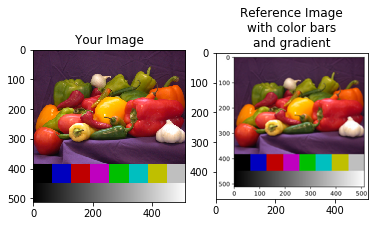

In [4]:
# Concatenate and show Image
plt.subplot(1,2,1)
img = np.concatenate( ( peppersImg, colorBar75, gradient), axis=0 )
plt.imshow( img );
plt.title("Your Image")
plt.subplot(1,2,2)
plt.imshow( plt.imread( "exercise_05_results_for_reference/peppers_bar_gradient.png" ), interpolation = 'catrom' );
plt.title("Reference Image\nwith color bars\nand gradient");

## 5.1 Histogram

Histograms are useful to see the distribution of code values between blacks, mid tones and highlights and to eliminate color casts. They can also be used to detect reduced quantization.

In [5]:
a = np.arange(12).reshape((3, 4))
print(a)
# [[ 0  1  2  3]
#  [ 4  5  6  7]
#  [ 8  9 10 11]]
print((4 <= a)  * (a < (4+2)) )
# [[ True  True  True  True]
#  [False False False False]
#  [False False False False]]

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
[[False False False False]
 [ True  True False False]
 [False False False False]]


<BarContainer object of 256 artists>

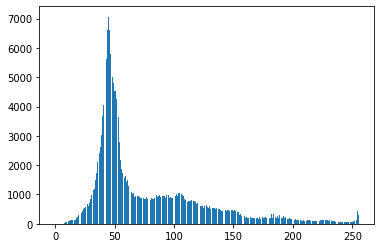

In [6]:
# Finish the function `calculateHistogramm` by looping over all bins and not using the Python histogram functions.
def calculateHistogramm(img, bins = 256, minval = 0.0, maxval = 1.0):
    # Tipps aus Fragestunde: erst von 0-1 auf 0-255 mappen, Forschleife/Vektorisieren...
    #histImg = (img-minval) / ( maxval - minval) * (bins-1)
    histImg = (img.clip(minval, maxval)-minval) /(maxval-minval)*(bins-1)
    lumaImg = (0.2126 * histImg[:,:,0] + 0.7152 * histImg[:,:,1] + 0.0722 * histImg[:,:,2])
    result = np.zeros(((bins)))

    for i in range (bins):
        result[i] = np.sum(np.around(lumaImg) == i )
        #result[i]  = np.sum((i <= lumaImg) * (lumaImg < i+1))
    
    return result

plt.bar(np.arange(0,256),calculateHistogramm(peppersImg))

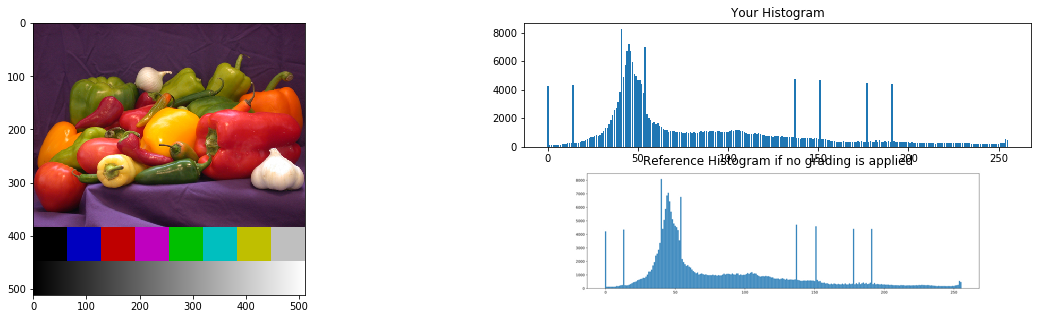

In [7]:
# Apply the ASC-CDL grading controls from 4.2 to get an intuition how the histogram behaves.
def luma(x):
    return 0.2126 * x[:,:,0] + 0.7152 * x[:,:,1] + 0.0722 * x[:,:,2]

def ascSlope(x, slope):
    return x * np.maximum(slope,0)

def ascOffset(x, offset):
    return x + offset
 
def ascPower(x, power):
    return np.power(x,np.maximum(power,0))

def ascSaturation(x, saturation):
    result = x.copy()
    result[:,:,0] = (luma(x) + saturation * (x[:,:,0] - luma(x)))
    result[:,:,1] = (luma(x) + saturation * (x[:,:,1] - luma(x)))
    result[:,:,2] = (luma(x) + saturation * (x[:,:,2] - luma(x)))
    return result.clip(0.0,1.0)

#print((luma(img) + saturation * (img[:,:,0] - luma(img) )).shape)


def ascGrade(x, slope, offset, power, saturation):
    return  ascSaturation(ascPower(ascOffset(ascSlope(x,slope),offset),power),saturation)

def luma(x):
    return 0.2126 * x[:,:,0] + 0.7152 * x[:,:,1] + 0.0722 * x[:,:,2]

def ascSlope(x, slope):
    return x * np.maximum(slope,0)

def ascOffset(x, offset):
    return x + offset
 
def ascPower(x, power):
    return np.power(x,np.maximum(power,0))

def ascSaturation(x, saturation):
    result = x.copy()
    result[:,:,0] = (luma(x) + saturation * (x[:,:,0] - luma(x)))
    result[:,:,1] = (luma(x) + saturation * (x[:,:,1] - luma(x)))
    result[:,:,2] = (luma(x) + saturation * (x[:,:,2] - luma(x)))
    return result.clip(0.0,1.0)

#print((luma(img) + saturation * (img[:,:,0] - luma(img) )).shape)


def ascGrade(x, slope, offset, power, saturation):
    return  ascSaturation(ascPower(ascOffset(ascSlope(x,slope),offset),power),saturation)

gradedImg = img

pepper_hist = calculateHistogramm( gradedImg )
hist_range  = np.arange(0, pepper_hist.shape[0])

# Display
plt.figure(figsize=(20,5))
plt.subplot(2,2,(1,3))
plt.imshow( gradedImg )
plt.subplot(2,2,2)
img = np.concatenate( ( peppersImg, colorBar75, gradient), axis=0 )
plt.bar(hist_range, pepper_hist);
plt.title("Your Histogram")
plt.subplot(2,2,4)
plt.imshow( plt.imread( "exercise_05_results_for_reference/histogram.png" ), interpolation = 'catrom' );
plt.axis('off')
plt.title("Reference Histogram if no grading is applied");

<BarContainer object of 256 artists>

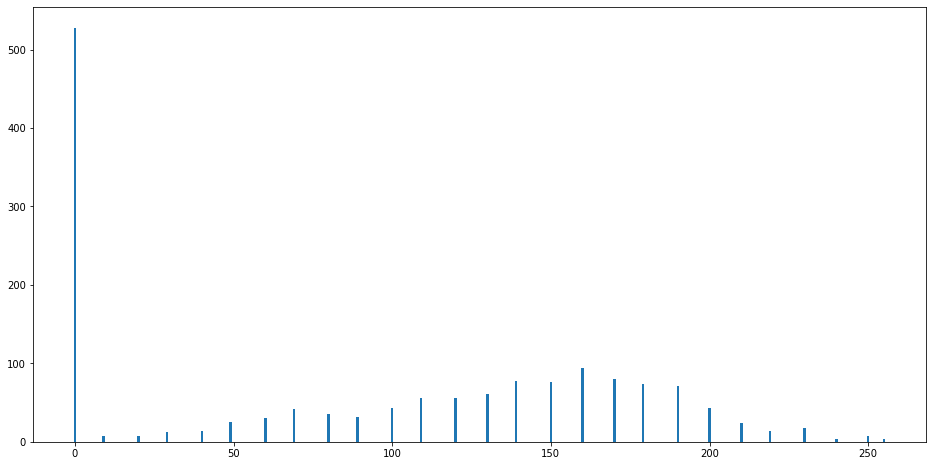

In [13]:
# Play with the histogram resolution to detect that peppers.png seems to be 8 bits.\n",
# Increasing the number of bins is one way to do this, but setting minval and maxval to appropriate numbers may be more clever. \n",
# Finish the function `calculateHistogramm` by looping over all bins and not using the Python histogram functions.\n",
def calculateHistogrammJustRed(img, bins = 256, minval = 0.0, maxval = 1.0):
    histImg = (img.clip(minval, maxval) - minval) / (maxval - minval) *(bins-1)
    lumaImg = (0.2126 * histImg[:,:,0] + 0.7152 * histImg[:,:,1] + 0.0722 * histImg[:,:,2])
    result = np.zeros(((bins)))
    for i in range (bins):
        result[i]  = np.sum((i <= histImg[0]) * (histImg[0] < i+1))
    return result

plt.bar(np.arange(0,256),calculateHistogrammJustRed(peppersImg,minval= 0.2,maxval= 0.3))
# Wenn das Histogramm nur einen kleinen Teilbereich darstellt wird ersichtlich, dass es große Lücken zwischen den einzelnen Helligkeitsstufen gibt. Das resultiert aus der 8 Bit Auflösung. Erwartung bei Wertebereich 0.2 - 0.3 (=1/10 der Farben-> 256/10 = 25,6 Balken in diesem Histogramm erwartet. 

In [14]:
from scipy.misc import imresize
# Try to hide the fact that peppers.png is only 8bits by resizing it.
# What may be a better choice than resizing? Would this solve visible quantization artifacts in the image?
res = imresize(peppersImg,(192, 256,3), interp = "bicubic")
# Your code here
# Your code here
# Your code here
# Your code here
# Your code here
# Your code here
# Your code here

ImportError: cannot import name 'imresize' from 'scipy.misc' (C:\Users\Simon\anaconda3\lib\site-packages\scipy\misc\__init__.py)

## 5.2 Waveform

A waveform monitor can be thought as being histogram per column, but the height of the histogram bar is now shown as pixel intensity. 

In [15]:
# Finish the function `calculateWaveform`.
#Waveform bildet die Breite der Image ab und zeigt in der Vertikalen die Helligkeitsverteilung
bitDept= 8
def calculateWaveform(img, bins = 256, minval = 0.0, maxval = 1.0):
    # Verschalchtelung mit Histogramm für jede Spalte einmal ausführen?
    histImg = (img.clip(minval, maxval)-minval) /(maxval-minval)*(bins-1)
    
    result = np.zeros((bins,img.shape[1],3))

    for j in range (img.shape[1]):
        for i in range (bins):
            result[i,j,0] = np.sum(np.around(histImg[:,j,0]) == i )
            result[i,j,1] = np.sum(np.around(histImg[:,j,1]) == i )
            result[i,j,2] = np.sum(np.around(histImg[:,j,2]) == i )
    #return result # Da fehlte der Flip, Histogram stand auf dem Kopf
       
    #print(result)

    #Hier aktuell die Frage was der teiler ist#Hier aktuell die Frage was der Teiler ist
    #Wir bearbeiten das "result" noch mal mit dem Log2 und teilen es durch die Bittiefe des Bildes.
    result = np.log2(result)/bitDept
    return np.flip(result,0)
    #Werte auf 255 reduzieren, kann man machen
    #return np.flip(result-(1/256), 0)

    #Ergibt ein übersteuertes Ergebnis, Problem evtl. das gleiche Werte Addiert werden in Result
    #return np.flip((result / np.maximum(result)*12), 0)

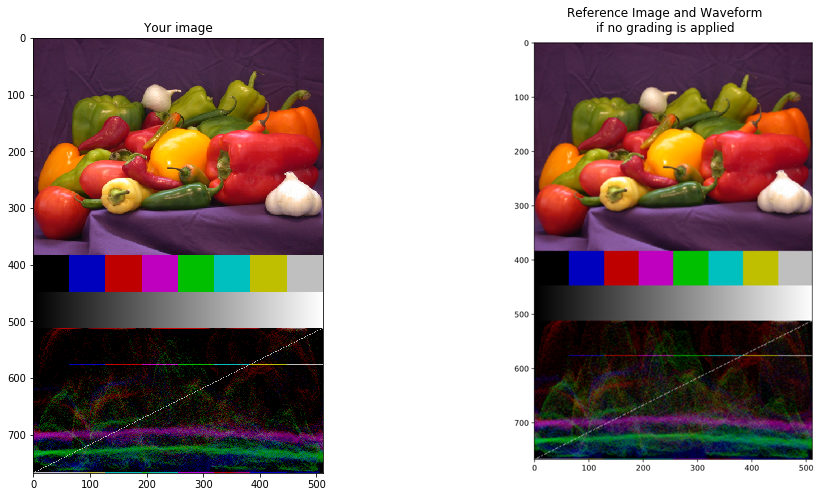

In [11]:
plt.rcParams['figure.figsize'] = (16.0, 8.0)
# Apply the grading controls from 4.2 and get an intuition how the waveform behaves.

gradedImg = img

wf = calculateWaveform(gradedImg, bins=256)
plt.subplot(1,2,1)
plt.imshow( np.concatenate( ( gradedImg, wf), axis=0 ) );
plt.title("Your image");
plt.subplot(1,2,2)
plt.imshow( plt.imread( "exercise_05_results_for_reference/img_and_waveform.png" ), interpolation = 'catrom' );
plt.axis('off')
plt.title("Reference Image and Waveform\nif no grading is applied");

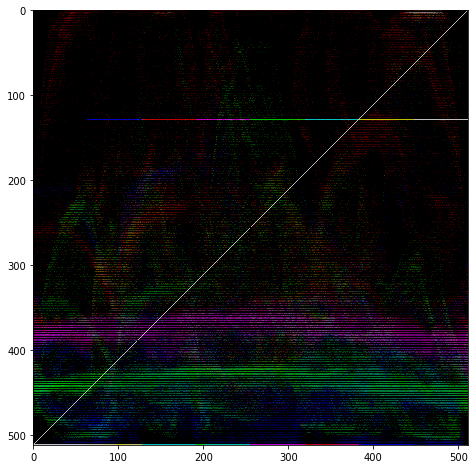

In [12]:
# Change the bins to 512. How can you detect limited tonal resolution using a waveform? Did you already observe this in grading?
# Your code here
# Your code here
# Your code here
plt.imshow(calculateWaveform(img, bins=512) )

## 5.3 Vectorscope
Colorist often use the vectorscope to adjust color balance. 

In [62]:
# Finish the function `calculateVectorscope`.
# Hint: For calculating the 2D histogram ‘accum’ will be much faster compared to two loops

'''def calculateVectorscope(img, bins=256):
    lumaImg = (0.2126 * histImg[:,:,0] + 0.7152 * histImg[:,:,1] + 0.0722 * histImg[:,:,2])
    v = (img[:,:,0]-lumaImg) * 0.877
    u = (img[:,:,2]-lumaImg) * 0.493
    result = np.zeros((bins,bins))
        for j in range (img.shape[1]):
        for i in range (bins):
            result[i,j,0] = np.sum(np.around(histImg[:,j,0]) == i )
            result[i,j,1] = np.sum(np.around(histImg[:,j,1]) == i )
            result[i,j,2] = np.sum(np.around(histImg[:,j,2]) == i )

    result = np.log2(result)/bitDept
    return np.flip(result, axis=0)'''

def calculateVectorscope(img, bins=256):
    result = np.zeros((bins-1,bins-1))
    for i in range(np.shape(img)[0]):
        for j in range(np.shape(img)[1]):
            #y = 0.299 * img[i,j,0] + 0.587 * img[i,j,1] + 0.114 * img[i,j,2]
            y = (0.2126 * img[i,j,0] + 0.7152 * img[i,j,1] + 0.0722 * img[i,j,2])
            #u = 0.493 * (img[i,j,2] - y)
            #v = 0.877 * (img[i,j,0] - y)
            u = 0.6 * (img[i,j,2] - y)
            v = 0.7 * (img[i,j,0] - y)
            result[int(v*bins) + int(bins/2 -1), int(u*bins) + int(bins/2 -1)] += 0.5
    #print(result)
    return np.flip(result, axis=0)

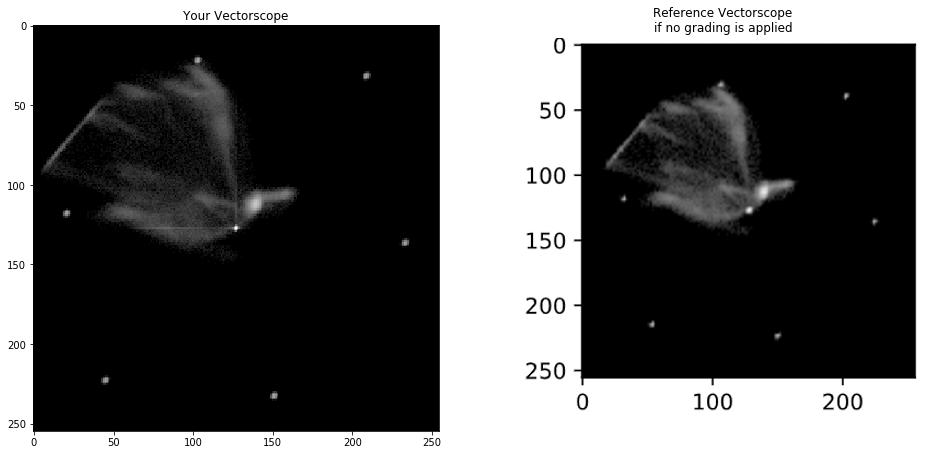

In [63]:
# Add some noise to the image before feeding it into the vectorscope so that the color bars do not only end up at the same pixel position.
noise_img = img + (np.random.randn(img.shape[0], img.shape[1], 3) - 0.5) / 256

vectorscopeOutput = calculateVectorscope( noise_img )

plt.subplot(1,2,1)
plt.imshow(np.log2(vectorscopeOutput + 1) / np.log2(np.amax( vectorscopeOutput ) + 1), cmap='gray', vmin=0, vmax=1.0)
plt.title("Your Vectorscope");
plt.subplot(1,2,2)
plt.imshow( plt.imread( "exercise_05_results_for_reference/vectorscope.png" ), interpolation = 'catrom' );
plt.axis('off')
plt.title("Reference Vectorscope\nif no grading is applied");

In [37]:
# Apply the grading controls from 4.2 and get an intuition how the vectorscope behaves. Especially try saturation
# Your code here
# Your code here
# Your code here
# Your code here
gradedImg = # Your code here
# Your code here
# Your code here
# Your code here
# Your code here

SyntaxError: invalid syntax (<ipython-input-37-3912cbfd8c99>, line 6)